# Frequency Bias Experiments

Main repository for experiment. Select a dataset, architecture and model weight and it will estimate the frequency bands and perform MDA, producing a bar graph of the result

In [31]:
%load_ext autoreload
%autoreload 2
import datasets
import utils
import numpy as np
import hyperopt as hp
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Available options

In [9]:
datasets.show_available()

Available datasets: CIFAR10


In [273]:
# Choose 
DATASET_NAME = "CIFAR10"
#ARCH = 
#WEIGHTS = 
PERCENT = 0.2 # we suggest 0.2 for CIFAR10 and 0.1 for everything else

### Load Dataset and define bands

In [20]:
# Choose Dataset - check which ones are available
dataset = datasets.get_dataset(DATASET_NAME)

### Define Frequency Bands - Wait do we need this?
Remember our theoretical energy distribution:

$\mathbb{E}[\text{energy[i, j]}] = \frac{A}{||(i, j)||_1^{\alpha}}$

We will adjust $A$ and $\alpha$ for this dataset using hyperopt to match the empirical distribution (represented here as the average energy per band on the test dataset)


In [276]:
X_test, _ = dataset.get_testset_natural()
dataset_shape = X_test.shape[1], X_test.shape[2]
emp_dist = utils.get_mean_energy_dataset(X_test)

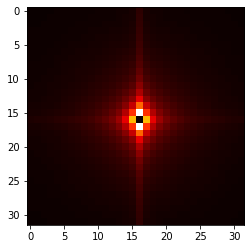

In [277]:
plt.imshow(emp_dist, cmap="hot")

Text(0.5, 1.0, 'Energy Distribution (CIFAR10)')

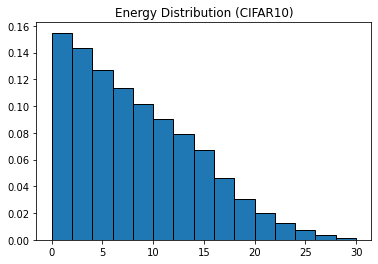

In [278]:
steps = np.arange(0, 32, 2)
height, width = utils.get_energy_histogram(emp_dist, steps)
plt.bar(steps[:-1], height, width, edgecolor="black", align="edge")
plt.title("Energy Distribution (CIFAR10)")

Text(0.5, 1.0, 'Energy Distribution (CIFAR10)')

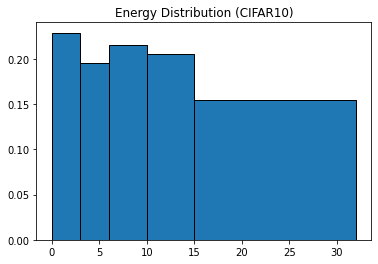

In [279]:
percent_range = utils.get_percentage_masks_relevance(emp_dist, PERCENT)
height, width = utils.get_energy_histogram(emp_dist, percent_range)
plt.bar(percent_range[0:-1], height, width, edgecolor="black", align="edge")
plt.title("Energy Distribution (CIFAR10)")

### Load Model and Weights

In [243]:
#todo

# Appendix

### Optional: visualize dataset images

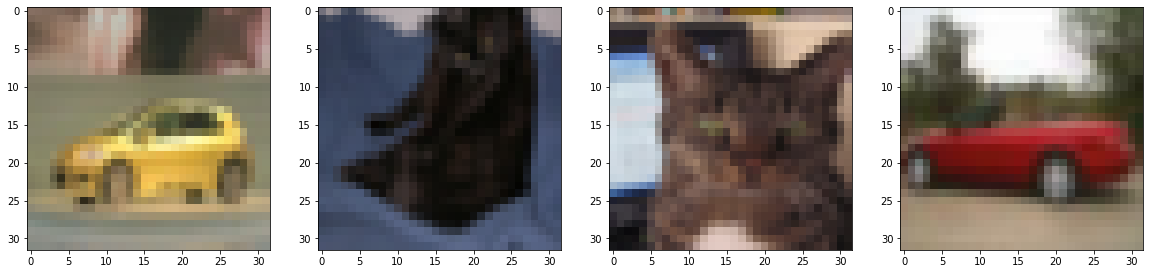

In [45]:
chosen = np.random.choice(np.arange(X_test.shape[0]), 4, replace=False)
Xchosen = X_test[chosen]

plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.imshow(Xchosen[0])
plt.subplot(1, 4, 2)
plt.imshow(Xchosen[1])
plt.subplot(1, 4, 3)
plt.imshow(Xchosen[2])
plt.subplot(1, 4, 4)
plt.imshow(Xchosen[3])

### Optional: visualize images filtered

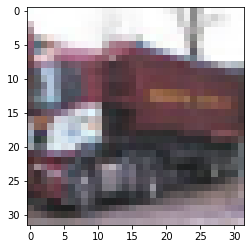

In [260]:
# assuming X_test, emp_dist and percent_range already calculated
chosen = np.random.choice(np.arange(X_test.shape[0]))
Xchosen = X_test[chosen]
_ = plt.imshow(Xchosen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


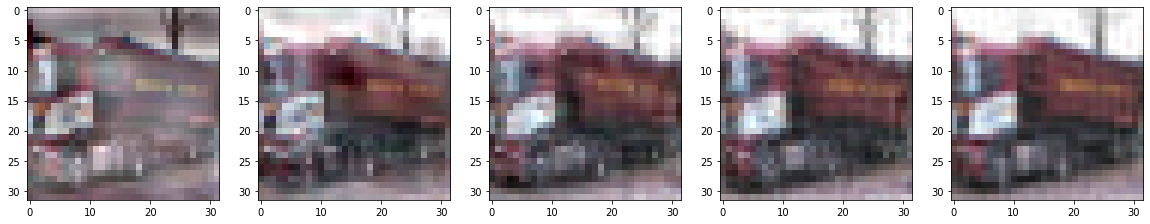

In [280]:
plt.figure(figsize=(20, 10))

for i in range(len(percent_range) - 1):
    nowchosen = utils.remove_frequency_ring(Xchosen, percent_range[i], percent_range[i + 1])
    plt.subplot(1 + int(len(percent_range) > 6), 5, i + 1)
    plt.imshow(nowchosen)